In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [39]:
layer_num=3
hidden_num=64

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [40]:
def potential(x):
    poten=2*x*torch.sin(torch.pi*x)+x**2*2
    return poten

In [41]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 3000   # number of interior points # 对时间成本来说几乎是平方量
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=120
extend_num=0
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


/tmp/ipykernel_701684/2513471731.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


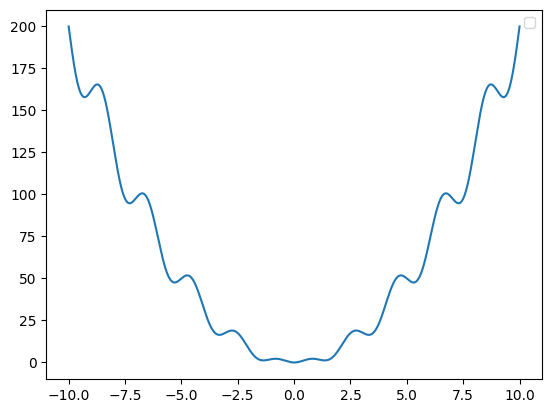

In [42]:
# 势函数演示图像
x_test=torch.linspace(La, Lb, N+2)
f1_test=potential(x_test)
plt.plot(x_test.numpy(), f1_test.numpy())
plt.legend()
plt.show()

In [43]:
# 计算初始的本征值
V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

print('initial eigenvalues check:')
print(eigenvalues[:en_num])

en=eigenvalues[:en_num]

initial eigenvalues check:
tensor([  1.4051,   2.8637,   3.8748,   6.0232,   8.3985,  10.8997,  13.5647,
         16.1873,  18.3476,  19.2365,  20.0208,  21.8431,  23.8551,  25.7464,
         27.7052,  29.8368,  32.0801,  34.3924,  36.7631,  39.1887,  41.6547,
         44.1339,  46.6004,  48.9638,  50.7529,  51.3661,  52.1823,  54.0633,
         56.0416,  57.8436,  59.5758,  61.4134,  63.3925,  65.4539,  67.5548,
         69.6934,  71.8757,  74.1021,  76.3691,  78.6700,  80.9997,  83.3534,
         85.7288,  88.1165,  90.5103,  92.8943,  95.2490,  97.4823,  98.9329,
         99.3544, 100.3460, 102.3236, 104.3003, 106.0898, 107.7433, 109.4320,
        111.2589, 113.1973, 115.1849, 117.1967, 119.2290, 121.2943, 123.3936,
        125.5260, 127.6874, 129.8753, 132.0872, 134.3219, 136.5791, 138.8536,
        141.1467, 143.4529, 145.7731, 148.1036, 150.4412, 152.7797, 155.1147,
        157.4338, 159.7174, 161.8554, 162.9356, 163.2649, 164.5328, 166.5711,
        168.5560, 170.3608, 171.9956,

In [44]:
b_80_24000=torch.tensor([  1.4057,   2.8649,   3.8761,   6.0228,   8.4002,  10.9028,  13.5621,
         16.1886,  18.3487,  19.2355,  20.0209,  21.8407,  23.8569,  25.7458,
         27.7077,  29.8363,  32.0812,  34.3912,  36.7595,  39.1870,  41.6520,
         44.1322,  46.5992,  48.9636,  50.7544,  51.3653,  52.1824,  54.0650,
         56.0419,  57.8447,  59.5764,  61.4141,  63.3920,  65.4539,  67.5551,
         69.6905,  71.8785,  74.1022,  76.3730,  78.6689,  80.9975,  83.3547,
         85.7279,  88.1167,  90.5106,  92.8951,  95.2494,  97.4830,  98.9343,
         99.3526, 100.3456, 102.3239, 104.3018, 106.0898, 107.7427, 109.4312,
        111.2587, 113.1987, 115.1861, 117.2006, 119.2252, 121.2934, 123.3883,
        125.5279, 127.6903, 129.8758, 132.0883, 134.3218, 136.5795, 138.8527,
        141.1471, 143.4537, 145.7748, 148.1043, 150.4405, 152.7802, 155.1142,
        157.4346, 159.7181, 161.8551, 162.9265, 163.2528, 164.5288, 166.5670,
        168.5487, 170.3460, 171.9657, 173.5610, 175.2816, 177.1364, 179.0628,
        181.0118, 182.9722, 184.9469, 186.9477, 188.9768, 191.0340, 193.1180,
        195.2217, 197.3448, 199.4874, 201.6476, 203.8266, 206.0213, 208.2335,
        210.4574, 212.6972, 214.9498, 217.2130, 219.4864, 221.7705, 224.0602,
        226.3569, 228.6560, 230.9566, 233.2546, 235.5454, 237.8204, 240.0553,
        242.0897],dtype=dtype,device=device)
c_10_24000=torch.tensor([  2.0302,   3.3522,   4.7160,   5.8941,  11.2383,  11.3056,  11.8813,
         16.6050,  18.0880,  18.2597,  20.1634,  23.2911,  24.5328,  25.1654,
         26.8757,  28.2906,  32.1927,  33.6333,  38.0034,  38.6101,  40.4730,
         46.1747,  46.5688,  49.0112,  50.9683,  51.2082,  53.0825,  53.9171,
         54.8885,  56.0377,  59.2819,  61.6410,  64.0177,  65.9201,  66.0514,
         70.6874,  70.7416,  73.7237,  75.0689,  79.0238,  81.7475,  83.8968,
         86.1511,  87.7685,  89.8179,  93.3768,  95.9385,  96.5630,  97.1659,
         99.8427, 101.2662, 103.8117, 105.1198, 105.9782, 107.9486, 108.1130,
        111.8143, 112.2743, 113.7710, 117.0756, 119.3185, 120.8503, 121.7392,
        125.1761, 127.8096, 130.4879, 132.5258, 133.8669, 136.9681, 138.7888,
        141.5076, 143.7892, 145.7170, 148.9525, 150.2399, 152.1374, 155.3147,
        157.2502, 159.7646, 162.0020, 162.8215, 163.8655, 164.7433, 165.0089,
        169.4279, 170.6648, 171.4458, 172.9577, 174.9376, 176.8626, 180.3920,
        180.8486, 181.9782, 185.2195, 187.0663, 189.0826, 190.7703, 193.1158,
        196.9575, 198.0450, 199.6045, 203.2864, 203.9969, 206.9127, 210.1586,
        212.0166, 215.4978, 217.3205, 219.1032, 223.0738, 223.4961, 226.9039,
        230.8727, 230.8988, 235.1141, 236.9131, 240.5372, 243.8421, 245.6595,
        248.8976], dtype=dtype,device=device)

In [47]:
error=en-b_80_24000
error_2=en-c_10_24000
print('average error:',torch.mean(torch.abs(error)))
print('average error_2:',torch.mean(torch.abs(error_2)))

average error: tensor(0.5312, device='cuda:5', grad_fn=<MeanBackward0>)
average error_2: tensor(0.6424, device='cuda:5', grad_fn=<MeanBackward0>)


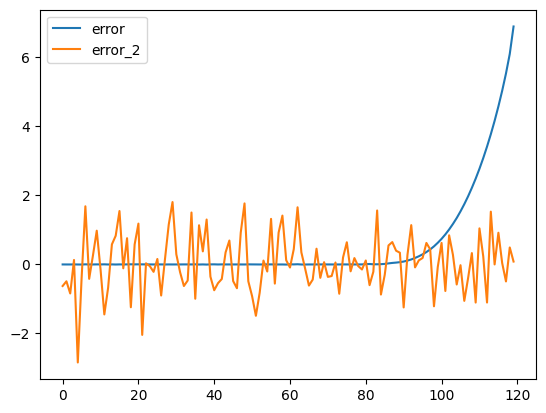

In [46]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(error_2.detach().cpu().numpy(),label='error_2')
# plt.plot(error_3.detach().cpu().numpy(),label='error_3')
plt.legend()
plt.show()